# Laptops Price Dataset
This dataset provides a comprehensive collection of information on various laptops, enabling a detailed analysis of their specifications and pricing. It encompasses a wide range of laptops, encompassing diverse brands, models, and configurations, making it a valuable resource for researchers, data analysts, and machine learning enthusiasts interested in the laptop industry.

The data comes from the spanish website PC componentes. The data was collected using Power Automate, more info on: https://github.com/juanmerino89/laptops-data-cleaning

#### Fields included:

- **Laptop Name**: The unique identifier or model name of the laptop.
- **Brand**: Laptop brand.
- **Model**: Laptop brand model.
- **CPU (Central Processing Unit)**: The processor brand, model, and other relevant details.
- **GPU (Graphics Processing Unit)**: The graphics card brand, model, and associated specifications.
- **RAM (Random Access Memory)**: The amount of memory available for multitasking.
- **Storage**: The storage type (HDD, SSD) and capacity of the laptop.
- Price: The cost of the laptop in the respective currency.

By utilizing this dataset, researchers and analysts can explore patterns, trends, and relationships between laptop specifications and their pricing. It serves as an excellent resource for tasks such as price prediction, market analysis, and comparison of different laptop configurations. Whether you are interested in identifying the most cost-effective options or understanding the impact of specific hardware components on laptop prices, this dataset offers abundant possibilities for in-depth exploration.

In [ ]:
!pip3 install pandas
!pip3 install scikit-learn
!pip3 install torch
!pip3 install matplotlib

# Extract the dataset

In [68]:
import pandas as pd

data_url = 'https://raw.githubusercontent.com/juanmerino89/laptops-data-cleaning/main/laptops.csv'
data_raw_df = pd.read_csv(data_url)

data_raw_df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [69]:
X_raw = data_raw_df.drop("Final Price", axis=1)
X_raw = X_raw.drop("Laptop", axis=1)
Y = data_raw_df["Final Price"]

In [70]:
from sklearn.model_selection import train_test_split

X_raw_train, X_raw_test, Y_train, Y_test = train_test_split(X_raw, Y, test_size=0.2, random_state=123)

# EDA
Perform EDA on the datsaet to understand the data.

In [71]:
data_raw_df.shape

(2160, 12)

### describe the numeric fields

In [72]:
data_raw_df.describe()

,RAM,Storage,Screen,Final Price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


### Check for nan values

In [73]:
df = data_raw_df.isna().sum()
df

Laptop             0
Status             0
Brand              0
Model              0
CPU                0
RAM                0
Storage            0
Storage type      42
GPU             1371
Screen             4
Touch              0
Final Price        0
dtype: int64

### check values counts of categorical features

In [74]:
import pandas as pd

categorical_features = ["Status", "Brand", "Storage type", "Touch", "GPU", "CPU", "Model"]
text_features = ["Laptop"]
num_features = [ "RAM", "Storage", "Screen"]

cat_uniq_values = []
for cat_feat in categorical_features:
    cat_uniq_values.append({
        "feat": cat_feat, 
         "values": len(data_raw_df[cat_feat].unique())
    })

cat_uniq_values

[{'feat': 'Status', 'values': 2},
 {'feat': 'Brand', 'values': 27},
 {'feat': 'Storage type', 'values': 3},
 {'feat': 'Touch', 'values': 2},
 {'feat': 'GPU', 'values': 45},
 {'feat': 'CPU', 'values': 28},
 {'feat': 'Model', 'values': 121}]

### Storage type

In [75]:
data_raw_df["Storage type"].value_counts()


Storage type
SSD     2062
eMMC      56
Name: count, dtype: int64

### Screen

In [76]:
data_raw_df["Screen"].value_counts().head(5)

Screen
15.6    1009
14.0     392
16.0     174
17.3     161
13.3     131
Name: count, dtype: int64

### Impute

In [77]:
class LaptopDataImputer():
    
    def __init__(self):
        self._most_frequent_columns = [ "Storage type", "Screen" ]
        self._const_columns = [ {'name': "GPU", 'value': ''} ]
        self.fit_values = []
    
    def fit(self, df):
        for col_name in self._most_frequent_columns:
            freq_value = df[col_name].unique()[0]
            self.fit_values.append({'name': col_name, 'value': freq_value})
        
        for col in self._const_columns:
            self.fit_values.append(col)
    
    def transform(self, df):
        for col in self.fit_values:
            df[col['name']] = df[col['name']].fillna(col['value'])
            
        return df
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

imputer = LaptopDataImputer()
imputer.fit(X_raw_train)

## Transforming columns

In [78]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

categories = []
data_df = imputer.transform(data_raw_df)
for feat in categorical_features:
    categories.append(data_df[feat].unique())
    
transformer = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(drop="if_binary", sparse_output=False, categories=categories), categorical_features),
    remainder="passthrough",
    verbose_feature_names_out=False
)

In [79]:
X_train = X_raw_train.copy()
X_train = imputer.transform(X_train)
transformer.fit(X_train)

X_transformed = transformer.transform(X_train)
X_train = pd.DataFrame(
    X_transformed, 
    columns=transformer.get_feature_names_out(),
    index=X_train.index
)
print("train ->", X_train.shape)


X_test = X_raw_test.copy()
X_test = imputer.transform(X_test)
X_test = pd.DataFrame(
    transformer.transform(X_test), 
    columns=transformer.get_feature_names_out(),
    index=X_test.index
)
print("test ->", X_test.shape)


train -> (1728, 227)
test -> (432, 227)


In [89]:
X_train_desc = X_train.describe().T
X_train_desc

,count,mean,std,min,25%,50%,75%,max
RAM,1728.0,0.188252,0.159445,0.0,0.066667,0.200000,0.200000,1.0
Storage,1728.0,0.141250,0.090287,0.0,0.056452,0.120968,0.243952,1.0
Screen,1728.0,0.641046,0.151434,0.0,0.493671,0.696203,0.696203,1.0
Status_Refurbished,1728.0,0.301505,0.459044,0.0,0.000000,0.000000,1.000000,1.0
Brand_Asus,1728.0,0.194444,0.395887,0.0,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...
Model_V330,1728.0,0.000579,0.024056,0.0,0.000000,0.000000,0.000000,1.0
Model_Alpha,1728.0,0.001157,0.034011,0.0,0.000000,0.000000,0.000000,1.0
Model_Delta,1728.0,0.000579,0.024056,0.0,0.000000,0.000000,0.000000,1.0
Model_GL65,1728.0,0.000579,0.024056,0.0,0.000000,0.000000,0.000000,1.0


# Train the FNN model.

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input_dim = X_train.shape[1]

class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        
        hidden_dim1 = int(X_train.shape[1]*3)
        hidden_dim2 = int(X_train.shape[1]*2)
        hidden_dim3 = int(X_train.shape[1]*0.5)
        
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
    
    def forward(self, x):
        _x = F.relu(self.fc1(x))
        _x = F.relu(self.fc2(_x))
        # _x = F.relu(self.fc3(_x))
        return self.output(_x)

net = FNet()
print(net)

FNet(
  (fc1): Linear(in_features=227, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)


In [105]:
from torch.nn import MSELoss 
from torch.optim import SGD
import numpy as np

def train(model, dataloader, optimizer=None, criterion=MSELoss(), epochs=50):
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    
    for epoch in range(epochs):    
        train_loss = 0
        num_batches = 0
        
        for X, Y in dataloader:
            optimizer.zero_grad()   # zero the gradient buffers
            
            Y_pred = model(X)
            
            loss = criterion(Y_pred, Y)
            
            train_loss += loss.item()
            num_batches += 1
            
            loss.backward()
            
            optimizer.step()
        
        epoch_loss = train_loss/num_batches
        train_losses.append(epoch_loss)
        
        if epoch%10 == 0:
            print("Epoch: {}/{} ".format(epoch + 1, epochs),
                  "Training Loss: {:.4f} ".format(epoch_loss))
            
    return train_losses


def test(model, dataloader, criterion=MSELoss(), epochs=50):
    test_losses = []
        
    for epoch in range(epochs):    
        min_test_loss = np.inf
        
        for X, Y in dataloader:
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            min_test_loss = np.min([min_test_loss, loss.detach().numpy()])
            
        epoch_loss = min_test_loss
        test_losses.append(epoch_loss)
        
        if epoch%10 == 0:
            print("Epoch: {}/{} ".format(epoch + 1, epochs),
                  "Test Loss: {:.4f} ".format(epoch_loss))
    
    return test_losses

In [109]:
import torch

X_train_tensor = torch.as_tensor(X_train.to_numpy()).type(torch.FloatTensor)
Y_train_tensor = torch.as_tensor(Y_train.to_numpy()).type(torch.FloatTensor).view(-1, 1)

X_test_tensor = torch.as_tensor(X_test.to_numpy()).type(torch.FloatTensor)
Y_test_tensor = torch.as_tensor(Y_test.to_numpy()).type(torch.FloatTensor).view(-1, 1)


torch.manual_seed(0) # set seed to make results reproducible

batch_size = 64 # Set the batch_size
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

net = FNet()
train_loss = train(net, trainloader, epochs=100)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

test_loss = test(net, testloader, epochs=100)

Epoch: 1/100  Training Loss: 2493326.3935 
Epoch: 11/100  Training Loss: 226538.6348 
Epoch: 21/100  Training Loss: 124637.9650 
Epoch: 31/100  Training Loss: 105801.0448 
Epoch: 41/100  Training Loss: 97593.9447 
Epoch: 51/100  Training Loss: 93050.5794 
Epoch: 61/100  Training Loss: 89765.4187 
Epoch: 71/100  Training Loss: 87681.4465 
Epoch: 81/100  Training Loss: 86838.1808 
Epoch: 91/100  Training Loss: 84729.4554 
Epoch: 1/100  Test Loss: 68881.5703 
Epoch: 11/100  Test Loss: 80985.1094 
Epoch: 21/100  Test Loss: 38835.4961 
Epoch: 31/100  Test Loss: 53037.6133 
Epoch: 41/100  Test Loss: 81446.4297 
Epoch: 51/100  Test Loss: 62332.6641 
Epoch: 61/100  Test Loss: 73412.1172 
Epoch: 71/100  Test Loss: 66867.5391 
Epoch: 81/100  Test Loss: 70014.6797 
Epoch: 91/100  Test Loss: 67467.6172 


# Plot the train loss vs Validation loss.

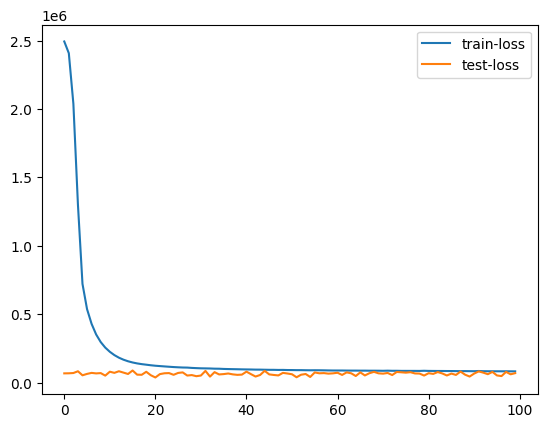

In [120]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train-loss")
plt.plot(test_loss, label="test-loss")
plt.legend(loc='upper right')
plt.show()
